# Animals recognition


In this project we will build Convolutional Network to recognize animals in the images. As the result, we get a resnet model and basic network training structure.

To achieve this goal we will be using Torch package to train and build model. To create image transforms we will experiment with albumentations library, which is proven to be faster then torch's implemantation.

This notebook consists of following segments:
1. Animals DataSet
2. Model building
3. Training
4. Evaluation
5. Making predictions
6. Summary

You might be interested in cheking correspoding post --**on my blog**--



Interesting links:
* https://sgugger.github.io/convolution-in-depth.html
* https://setosa.io/ev/image-kernels/

Links about NN-s:
* [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf)
* [A DISCIPLINED APPROACH TO NEURAL NETWORK, HYPER-PARAMETERS: PART 1 – LEARNING RATE, BATCH SIZE, MOMENTUM, AND WEIGHT DECA](https://arxiv.org/pdf/1803.09820.pdf)


Firstly, lets import necessery modules

*Note*: I am going to import some modules across the notebook to make code more accessible

In [1]:
!pip install albumentations --upgrade --quiet

!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet

In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2

#1. Animals Dataset 

Lets download data from google drive usings its id

In [3]:
#necessery upgrade
!pip install --upgrade --no-cache-dir gdown --quiet

# download the data
!gdown --id 1pNA7vRjcV3vs3geW4OzttsU65T0aZF4v

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pNA7vRjcV3vs3geW4OzttsU65T0aZF4v
To: /content/animals-10.zip
100% 614M/614M [00:06<00:00, 101MB/s] 


In [4]:
import os
import zipfile

#extract data to /data directory
with zipfile.ZipFile('./animals-10.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')


Now we need to rename classes of pictures from italian to english.

In [5]:
import os.path 
import shutil

def rename_classes(folder_dir):
  """rename classes from italian to english"""

  #transalations
  categories = {'cane': 'dog', "cavallo": "horse", "elefante": "elephant", 
                "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
                "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
                "ragno":"spider"}

  #translate
  for fn in os.listdir(folder_dir):
    if fn in categories.keys():
      os.rename(os.path.join(folder_dir, fn),
                os.path.join(folder_dir, categories[fn]))

  print(os.listdir(folder_dir))

def rename_files(fo_dir):
  """renames files based on classes"""
  folders = os.listdir(fo_dir)
  for folder in folders:
    folder_dir = fo_dir+'/'+folder+'/'
    for index, filename in enumerate(os.listdir(folder_dir)):
      os.rename(os.path.join(folder_dir, filename), os.path.join(folder_dir, f'{folder}_{index}.jpg'))
      
img_dir = '/content/data/raw-img'
rename_classes(img_dir)
rename_files(img_dir)

['dog', 'butterfly', 'cat', 'sheep', 'horse', 'cow', 'chicken', 'squirrel', 'elephant', 'spider']


##1.1. Spliting the data

Lets now split the data into train:test:val folders with split-folders module using 70:15:15 ratios respectively

In [6]:
!pip install split-folders --quiet

In [7]:
import splitfolders

#split data in folders
splitfolders.ratio(img_dir, output="./data", seed=1337, ratio=(.7, .15, .15))

shutil.rmtree(img_dir)
os.remove('./data/translate.py') 

Copying files: 26179 files [00:09, 2888.74 files/s]


Let's look inside one folder and specific classes

In [8]:
data_dir = './data'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train', 'val']
['dog', 'butterfly', 'cat', 'sheep', 'horse', 'cow', 'chicken', 'squirrel', 'elephant', 'spider']


In [9]:
elephant_files = os.listdir(data_dir + '/train/elephant')
print('No. of training examples of elephant: ', len(elephant_files))
print(elephant_files[:5])

No. of training examples of elephant:  1012
['elephant_1.jpg', 'elephant_622.jpg', 'elephant_349.jpg', 'elephant_828.jpg', 'elephant_222.jpg']


## 1.2. Data Transformations

We perform data transforamtion to make dataset more sparsem, by producing new images from ones that alreardy exist.

Thanks to spliting folders in such manner we can use the ImageFolder class from torchvision to load the data as PyTorch tensors

In [10]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader

Let's get the normalization stats that we will use to transform the pictures before training.

In [11]:
def get_norm_stats():
  torch.cuda.empty_cache()
  dataset = ImageFolder(data_dir + '/train', transform= T.Compose([T.Resize((128,128)),T.ToTensor()]))
  loader = DataLoader(dataset, batch_size=len(dataset), num_workers=1)
  data = next(iter(loader))
  return ((data[0][:][0].mean().item(), data[0][:][1].mean().item(), data[0][:][2].mean().item()),
          (data[0][:][0].std().item(), data[0][:][1].std().item(), data[0][:][2].std().item()))
stats= get_norm_stats()
#print(stats)

One way of transforming the data is using torch transformers:

In [44]:

train_tfms = T.Compose([T.Resize((224,224)),
                         T.RandomCrop(224, padding=22, padding_mode='reflect'), 
                         T.RandomHorizontalFlip(), 
                         #T.RandomRotation(20),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         T.ToTensor(), 
                         T.Normalize(*stats,inplace=True)])

valid_tfms = T.Compose([T.Resize((224,224)),T.ToTensor(), T.Normalize(*stats)])


In the project we are using albumentions library, as it has been proven to be faster then torch implementation of image transformation.

In [13]:
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

stats = ((0.4835536479949951, 0.7465012073516846, 0.21793095767498016), (0.18606126308441162, 0.325153648853302, 0.28472670912742615))

class Train_Tfms:
    def __init__(self):
        self.transforms = A.Compose([A.Resize(250,250),
                             A.RandomCrop(224,224),
                             A.HorizontalFlip(),
                             A.Normalize(*stats),
                             ToTensorV2(),
                             ],)

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

class Valid_Tfms:
    def __init__(self):
        self.transforms = A.Compose([A.Resize(224,224),
                             A.Normalize(*stats),
                             ToTensorV2(),
                             ],)

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']


Lets check dataset classes

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


## 1.3 Data loading

Now we will specify datasets with correspoding trnasforms and create data loader objects.

In [15]:
train_ds = ImageFolder(data_dir + '/train', transform= Train_Tfms())
val_ds = ImageFolder(data_dir + '/val', transform= Valid_Tfms())
test_ds = ImageFolder(data_dir + '/test', transform= Valid_Tfms())

In [16]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

In [17]:
# define dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*4, num_workers=2, pin_memory=True)

Let's have a look how one batch of data looks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


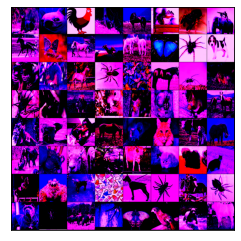

In [19]:
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_batch(dl):
  "plot example image batch after transforms"
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(4, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

show_batch(train_dl)

# 2. Building the Model

In [20]:
import torch.nn as nn
import torch.nn.functional as F

## 2.1. Move data loaders to GPU

Before we create our model lets define class DeviceDataLoader which will help us move created earlier data loading objects to GPU if we have one connected.

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
# use gpu if connected
device = get_default_device()

In [23]:
# move data loaders to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## 2.2. Define ResNet Model

Below we create backbone of our model.

In [24]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, base_width=64):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
            residual = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                residual = self.downsample(x)

            out += residual
            out = self.relu(out)

            return out



class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes=10):
      
      super(ResNet, self).__init__()
      
      self.inplanes = 64  #internal planes of bottleneck block
      self.base_width = 64
      
      self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.layer1 = self._make_layer(block, 64, layers[0])
      self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
      self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
      self.avgpool = nn.AvgPool2d(7, stride=1)
      self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample, self.base_width))
      self.inplanes = planes * block.expansion
      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes, base_width=self.base_width))

      return nn.Sequential(*layers)

  def forward(self, x):
        x = self.conv1(x)    # 224x224
        x = self.bn1(x)     
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112

        x = self.layer1(x)   # 56x56
        x = self.layer2(x)   # 28x28
        x = self.layer3(x)   # 14x14
        x = self.layer4(x)   # 7x7

        x = self.avgpool(x)  # 1x1
        x = x.flatten(1)
        x = self.fc(x)

        return x



In [27]:
def resnet23(**kwargs):
    model = ResNet(BasicBlock, [2, 3, 4, 2], **kwargs)
    return model

# define model
resnet_model = to_device(resnet23(num_classes=10), device)

Check if model's shapes is correct.

In [28]:
def model_chechup(train_dl, model):
  for images, labels in train_dl:
      print('images.shape:', images.shape)
      out = model(images)
      print('out.shape:', out.shape)
      print('out[0]:', out[0])
      break

model_chechup(train_dl, resnet_model)

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 10])
out[0]: tensor([-0.6657,  0.5699,  0.1110,  0.4151,  0.4258,  0.1579,  0.8462,  0.1599,
         0.1065, -0.1262], device='cuda:0', grad_fn=<SelectBackward0>)


Let's look for optimal learning rate.

In [29]:
#pip install torch-lr-finder

In [30]:
"""
from torch_lr_finder import LRFinder

model = resnet_model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
"""

'\nfrom torch_lr_finder import LRFinder\n\nmodel = resnet_model\ncriterion = nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)\nlr_finder = LRFinder(model, optimizer, criterion, device="cuda")\nlr_finder.range_test(train_dl, end_lr=100, num_iter=100)\nlr_finder.plot() # to inspect the loss-learning rate graph\nlr_finder.reset() # to reset the model and optimizer to their initial state\n'

# 3. Training the Model

In [31]:
from tqdm import tqdm

Let's define ``MetricMonitor`` class that stores metrics during training and helps us print it easily.

In [32]:
from collections import defaultdict

#Metric Monitor
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

Let's run the training with ``train`` func.

In [33]:
def calculate_accuracy(outputs, target):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == target).item() / len(preds)) 

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(train_loader, model, criterion, optimizer, lr_sched, grad_clip, epoch, epochs):
    """ train the model using criterion and chosen optimizer """
    metric_monitor = MetricMonitor()
    model.train()
    
    train_losses = []

    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):        
        output = model(images)
        loss = criterion(output, target)
        train_losses.append(loss)
        accuracy = calculate_accuracy(output, target)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Acc", accuracy)
        #metric_monitor.update("LR", get_lr(optimizer))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Gradient clipping
        if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        lr_sched.step()
        
        stream.set_description(
            f"Epoch [{epoch}/{epochs}]. Train.      {metric_monitor}"
            )
        stream.set_postfix(LR = get_lr(optimizer))
    
    train_loss = torch.stack(train_losses).mean().item()
    return train_loss

def validate(val_loader, model, criterion, epoch, epochs):
    """ validate the model """
    metric_monitor = MetricMonitor()
    model.eval()
    val_losses = []
    val_accs = []
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            output = model(images)
            loss = criterion(output, target)
            val_losses.append(loss)
            
            accuracy = calculate_accuracy(output, target)
            val_accs.append(accuracy)
            
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Acc", accuracy)
            stream.set_description(
                f"Epoch [{epoch}/{epochs}]. Validation. {metric_monitor}"
            )
    val_loss = torch.stack(val_losses).mean().item()
    val_acc = torch.stack(val_accs).mean().item()
    return {'val_loss': val_loss, 'val_acc': val_acc}

def fit_new(train_loader, val_loader, model, criterion, optimizer, max_lr, grad_clip, epochs):
  """ run the training looop for number of epochs and fit the model"""
  history = []
  torch.cuda.empty_cache()
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

  for epoch in range(1, epochs + 1):
      train_loss = train(train_loader, model, criterion, optimizer, sched, grad_clip, epoch, epochs)
      result = validate(val_loader, model, criterion, epoch, epochs)
      result['train_loss'] = train_loss
      history.append(result)
  return history

Define parameteres for training

In [34]:
#add preds
epochs = 20
max_lr = 0.01 
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss = F.cross_entropy

In [35]:
%%time
# add first record
history = [validate(val_dl, resnet_model, loss, 1, 1)]

# fit the model
history += fit_new(train_dl, val_dl, resnet_model, loss, opt_func, max_lr, grad_clip, epochs)

Epoch [1/1]. Validation. Loss: 2.299 | Acc: 0.090: 100%|██████████| 16/16 [00:20<00:00,  1.25s/it]
Epoch [1/20]. Train.      Loss: 1.744 | Acc: 0.392: 100%|██████████| 287/287 [02:21<00:00,  2.03it/s, LR=0.00104]
Epoch [1/20]. Validation. Loss: 1.978 | Acc: 0.339: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]
Epoch [2/20]. Train.      Loss: 1.484 | Acc: 0.487: 100%|██████████| 287/287 [02:19<00:00,  2.05it/s, LR=0.0028]
Epoch [2/20]. Validation. Loss: 1.719 | Acc: 0.408: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]
Epoch [3/20]. Train.      Loss: 1.349 | Acc: 0.538: 100%|██████████| 287/287 [02:19<00:00,  2.06it/s, LR=0.0052]
Epoch [3/20]. Validation. Loss: 1.718 | Acc: 0.411: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]
Epoch [4/20]. Train.      Loss: 1.242 | Acc: 0.575: 100%|██████████| 287/287 [02:20<00:00,  2.04it/s, LR=0.00761]
Epoch [4/20]. Validation. Loss: 1.589 | Acc: 0.454: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]
Epoch [5/20]. Train.      Loss: 1.163 | Acc: 0.

CPU times: user 32min 49s, sys: 11min 11s, total: 44min
Wall time: 52min 56s


# 4. Evaluation

Let's plot model accuracies.

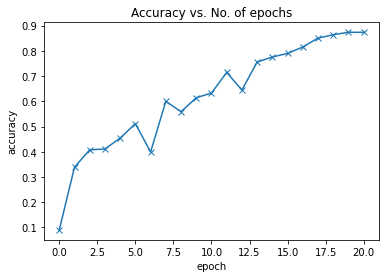

In [36]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

Let's plot the loss function training and validation ouput to inspect for overfitting. 

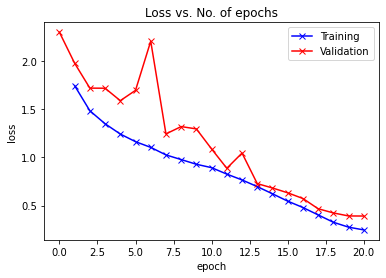

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# 5. Make predictions.

Define function to make predictions on given image.

In [38]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Let's make predictions on picture from test dataset

Label: cow , Predicted: cow


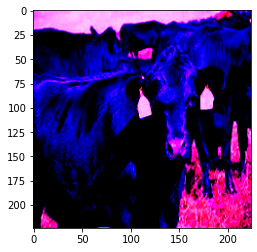

In [39]:
# pick a photo from testing data
img, label = test_ds[1129]

# plot the image
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, resnet_model))

# 4.1 Make predictions on your photo 

If u want u can add to working directiory your image and siply paste the path to it. Or paste link to a photo on internet in place of the example.

In [40]:
import requests
import shutil

url = 'https://giacostantino.com/images/ipynb/rtm_object_recognition.png'
file_name = 'dogo.png'

res = requests.get(url, stream = True)

if res.status_code == 200:
    with open(file_name,'wb') as f:
        shutil.copyfileobj(res.raw, f)
        print('Image sucessfully Downloaded: ',file_name)
else:
    print('Image Couldn\'t be retrieved')

Image sucessfully Downloaded:  dogo.png


Predicted: dog


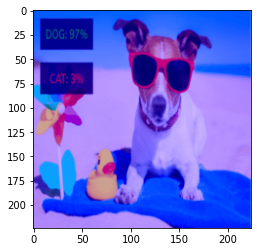

In [45]:
from PIL import Image


img_path = '/content/dogo.png'

#function that takes path of jpg file and transforms
def transform_photo(img_path):
  image = Image.open(img_path)
  return valid_tfms(image)

# predict image class
def predict_path(img_path, model):
  img = transform_photo(img_path)
  prediction = predict_image(img, model)
  invTrans = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.1675, 1/0.2972, 1/0.2550 ]),T.Normalize(mean = [ -0.3459, -0.4925, -0.5902 ],std = [ 1., 1., 1. ])])
  img = invTrans(img)
  plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
  print('Predicted:', prediction)

predict_path(img_path, resnet_model)

# 6. Summary

To sum up, we created in this notebook a traning pipeline for torch neural networks models, we proposed solution to image recognition problem using residual networks. However this is still much to explore, for example: what if we want to find a location of classified object? In fact, this is the definition of detection task in compute vision.

If you want to have some fun experimenting with the model, I suggest trying with depth of the network or training. hyperparameters like learning rate.